<style>
    @media print{
        body {
            position:relative !important;
        }
        .celltag_new_page {
            page-break-before: always !important;
        }
    }
</style>
# COMPSCI 527 Homework 2

_**Group Members:**_

Haoyang Ma

## Part 1: Linear Regression

In [1]:
import urllib.request
import ssl
from os import path as osp
import shutil


def retrieve(file_name, semester='spring24', homework=2):
    if osp.exists(file_name):
        print('Using previously downloaded file {}'.format(file_name))
    else:
        context = ssl._create_unverified_context()
        fmt = 'https://www2.cs.duke.edu/courses/{}/compsci527/homework/{}/{}'
        url = fmt.format(semester, homework, file_name)
        with urllib.request.urlopen(url, context=context) as response:
            with open(file_name, 'wb') as file:
                shutil.copyfileobj(response, file)
        print('Downloaded file {}'.format(file_name))

In [2]:
import pickle


file_name = 'noisy_line.pkl'
retrieve(file_name)
with open(file_name, 'rb') as file:
    noisy_line = pickle.load(file)

Downloaded file noisy_line.pkl


### Problem 1.1

In [3]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

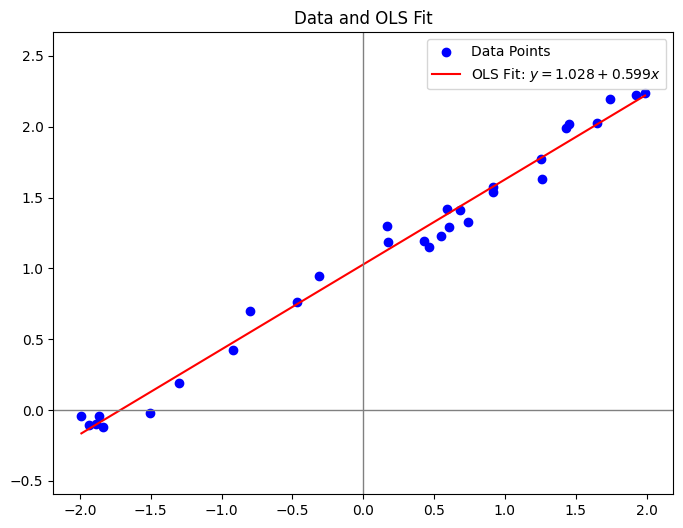

In [77]:
def add_bias(X):
    """在X的开始处添加一列1,用于偏置项"""
    ones = np.ones((X.shape[0], 1))
    return np.column_stack((ones, X))

def ols(t):
    """使用numpy.linalg.lstsq解决OLS问题,并返回解向量z"""
    X_with_bias = add_bias(t['x'])  # 为X添加偏置项
    y = t['y']
    z, residuals, rank, s = np.linalg.lstsq(X_with_bias, y, rcond=None)  # 解决OLS
    return z


def plot_data_and_ols_fit(x, y, z):
    """
    绘制数据点和OLS最优拟合线。
    
    参数:
    - x: 数据点的x坐标（numpy数组）。
    - y: 数据点的y坐标（numpy数组）。
    - z: OLS估计的参数（numpy数组），其中z[0]是截距，z[1]是斜率。
    """
    plt.figure(figsize=(8, 6))
    plt.scatter(x, y, color='blue', label='Data Points')
    
    # 计算最优拟合线的y值
    x_vals = np.linspace(x.min(), x.max(), 100)
    y_vals = z[0] + z[1] * x_vals
    
    plt.plot(x_vals, y_vals, color='red', label=f'OLS Fit: $y = {z[0]:.3f} + {z[1]:.3f}x$')
    
    # 绘制坐标轴线
    plt.axhline(0, color='gray', lw=1)
    plt.axvline(0, color='gray', lw=1)
    
    plt.legend()
    plt.axis('equal')
    plt.title('Data and OLS Fit')
    plt.show()

z = ols(noisy_line)
t = {'x': np.array([x for x in noisy_line['x']]), 'y': noisy_line['y']}
plot_data_and_ols_fit(t['x'], t['y'], z)

In [78]:
print(z)

[1.02768981 0.59940334]


### Problem 1.2 (Exam Style Except for the Code)

In [32]:

def residuals(z, t):

    X, y = t['x'], t['y']
    X_bias = add_bias(X)  
    phi = np.tensordot(X_bias, z, axes=1) - y  
    J = X_bias  
    return phi, J

def quadratic_risk(z, t, order):

    phi, J = residuals(z, t)
    # print(phi.shape)
    # print((phi**2).shape)
    risk = np.mean(phi**2)
    # print(risk.shape)
    if order == 0:
        return risk
    elif order == 1:
        gradient = 2 / len(phi) * np.tensordot(J.T, phi, axes=1)
        return risk, gradient, None
    elif order == 2:
        gradient = 2 / len(phi) * np.tensordot(J.T, phi, axes=1)
        hessian = 2 / len(phi) * np.tensordot(J.T, J, axes=1)
        return risk, gradient, hessian


z0 = np.array([0, 0])



print(z0.shape)
print(t['x'].shape)


(2,)
(30, 1)


In [38]:
r, g, h = quadratic_risk(z0, t, 2)
print(f"Risk: \n{r:.3f}, \n Gradient:\n {g}, \n Hessian:\n {h}")

Risk: 
1.818, 
 Gradient:
 [-2.2201058  -2.23034973], 
 Hessian:
 [[2.         0.27481692]
 [0.27481692 3.24977035]]


### Problem 1.3

In [85]:

def descent(fct, z0, step, order, delta=1.e-6, max_iterations=1000, record=True):
    history = {'z': [z0], 'L': []}
    z = z0
    for i in range(max_iterations):
        r, g, h = fct(z, order)[:3]  # 获取梯度和海森矩阵
        print(f"r:{r}")
        z_next = step(fct, z, g, h)  # 计算下一步位置
        if record:
            history['z'].append(z_next)
            print(f"fct(z_next, 0):{fct(z_next, 0)}")
            history['L'].append(fct(z_next, 0))
        if np.linalg.norm(z_next - z) < delta or np.linalg.norm(g) < delta:
            break
        z = z_next
    else:
        print("Warning: Maximum iterations reached.")

    result = (z, fct(z, 0))
    if record:
        return result + (history,)
    return result


In [87]:
def newton_step(fct, z, g, h):
    print(h.shape)
    print(h)
    h_inv = np.linalg.inv(h)  # 计算海森矩阵的逆
    step = np.tensordot(-h_inv , g, axes=1)  # 计算步长
    print(f"step:{step}")
    return z + step

In [88]:

def plot_contours_and_path(fct, history):
    # 创建网格
    x = np.linspace(-10, 10, 100)
    y = np.linspace(-10, 10, 100)
    X, Y = np.meshgrid(x, y)
    Z = np.array([fct(np.array([xi, yi]), 0) for xi, yi in zip(np.ravel(X), np.ravel(Y))])
    Z = Z.reshape(X.shape)
    
    # 绘制等高线
    plt.contour(X, Y, Z, levels=30, cmap='viridis')
    
    # 绘制路径
    zs = np.array(history['z'])
    plt.plot(zs[:, 0], zs[:, 1], 'r-', marker='o')  # 路径
    plt.plot(zs[-1, 0], zs[-1, 1], 'kx')  # 最后一个点
    
    plt.axis('equal')
    plt.title(f"Steps: {len(zs)-1}, Method: Newton, Solution: {zs[-1]}")
    plt.show()


r:1.8179994559319332
(2, 2)
[[2.         0.27481692]
 [0.27481692 3.24977035]]
step:[1.02768981 0.59940334]
fct(z_next, 0):0.008769864591225536
r:0.008769864591225536
(2, 2)
[[2.         0.27481692]
 [0.27481692 3.24977035]]
step:[ 2.72411980e-16 -7.02955123e-17]
fct(z_next, 0):0.008769864591225538


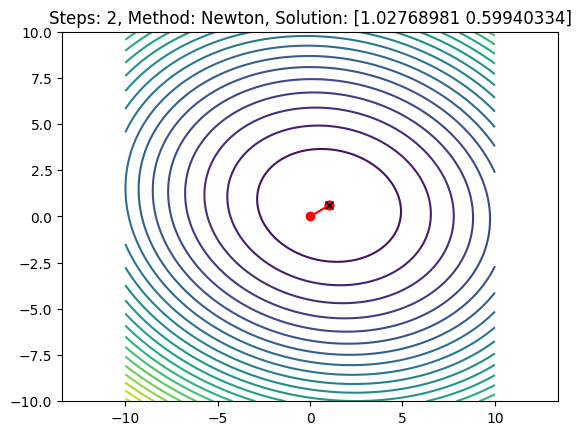

In [89]:
# 假设 quadratic_risk 已定义，t 是你的数据集
def risk_function(z, order):
    return quadratic_risk(z, t, order)

# 使用牛顿方法求解
z0 = np.array([0, 0])
result, risk, history = descent(risk_function, z0, newton_step, 2, record=True)

# 绘制结果
plot_contours_and_path(risk_function, history)

In [80]:
print(result)
print(z)

[1.02768981 0.59940334]
[1.02768981 0.59940334]


### Problem 1.4

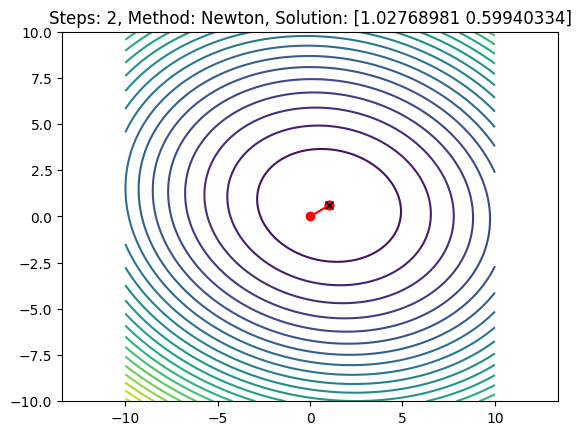

In [83]:

def newton_raphson(residual_fct, z0, delta=1.e-6, max_iterations=1000, record=True):
    if record:
        history = {'z': [z0], 'L': []}
    
    z = z0
    for i in range(max_iterations):
        residuals, J = residual_fct(z,t)  # 计算残差和雅可比矩阵
        g = 2 * np.tensordot(J.T , residuals, axes=1)  # 梯度
        H = 2 * np.tensordot(J.T , J, axes=1)  # 海森矩阵
        step = np.tensordot(-np.linalg.inv(H) , g, axes=1)  # 牛顿步
        z_next = z + step

        if record:
            history['z'].append(z_next)
            history['L'].append(np.mean(residuals**2))
        
        if np.linalg.norm(step) < delta:  # 检查收敛
            break
        z = z_next

    if record:
        return z, np.mean(residual_fct(z,t)[0]**2), history
    return z, np.mean(residual_fct(z,t)[0]**2)

z0 = np.array([0, 0])
z, risk, history = newton_raphson(residuals, z0)
# 绘制结果
plot_contours_and_path(risk_function, history)

### Problem 1.5

## Part 2: Robust Hyperplane Fitting

In [26]:
import autograd.numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [27]:
def tukey(u, tau):
    inside = np.abs(u) <= tau
    tau2 = tau ** 2
    tau4 = tau2 ** 2
    u2 = u ** 2
    u4 = u2 ** 2
    u6 = u4 * u2
    out_value = tau ** 2 / 6
    in_values = u2 / 2 - u4 / 2 / tau2 + u6 / 6 / tau4
    rho = out_value * ~inside + in_values * inside
    return rho

In [29]:
file_name = 'two_noisy_lines.pkl'
retrieve(file_name)
with open(file_name, 'rb') as file:
    points = pickle.load(file)

Using previously downloaded file two_noisy_lines.pkl


In [30]:
def plot_fit(dots, f=None, title=None, sampling=100):
    px, py = dots[::sampling, 0], dots[::sampling, 1]
    fig_size = figure_size(4, px, py)
    plt.figure(figsize=fig_size, tight_layout=True)
    plt.plot(px, py, '.', ms=5)
    if f is not None:
        x_range = (np.min(dots[:, 0]), np.max(dots[:, 0]))
        x = np.linspace(x_range[0], x_range[1], 2)
        y = f(x)
        plt.plot(x, y)
    plt.axis('equal')
    plot_axes()
    if title is None:
        pct = 100 / sampling
        plt.title('{:g} percent of all points'.format(pct))
    else:
        plt.title(title)
    plt.draw()

In [32]:
retrieve('sgd.py')
from sgd import CallCounter, run_sgd, plot_fit

Using previously downloaded file sgd.py


### Problem 2.1

### Problem 2.2 (Exam Style)

### Problem 2.3 (Exam Style Except for the Code Run)